# Выделение шестиугольников

Дано: произвольная картинка. Найти: список шестиугольников, каждый шестиугольник обрезать по bounding box и поместить на белый фон.

In [1]:
import cv2
import matplotlib.pyplot as plt

from collections import defaultdict
from glob import glob
from numpy import zeros

## Load

In [2]:
dir_path = '../images/'
files = glob(dir_path + '*.bmp')
images = {}
for file in files:
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    images[file[10:-4]] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [3]:
images.keys()

dict_keys(['Path_5', 'Single_8', 'Single_7', 'Single_9', 'Dozen_0', 'Path_6', 'Path_8', 'Group_3', 'Single_0', 'Single_4', 'Single_6', 'Group_5', 'Group_4', 'Path_10', 'Single_3', 'Group_6', 'Group_1', 'Single_1', 'Single_2', 'Path_9', 'Single_5', 'Group_2', 'Path_7', 'Path_4'])

In [4]:
def imshow(prefix, src, use_colors=False, figname=None):
    keys = [key for key in src.keys() if key.startswith(prefix)]
    n = len(keys)
    _, ax = plt.subplots(1, n, figsize=(n*6, 12))
    for i, key in enumerate(keys):
        if use_colors:
            ax[i].imshow(src[key])
        else:
            ax[i].imshow(src[key], cmap='gray')
        ax[i].axis('off')
        ax[i].set_title(key)
    if figname is not None:
        plt.savefig(figname + '.svg')

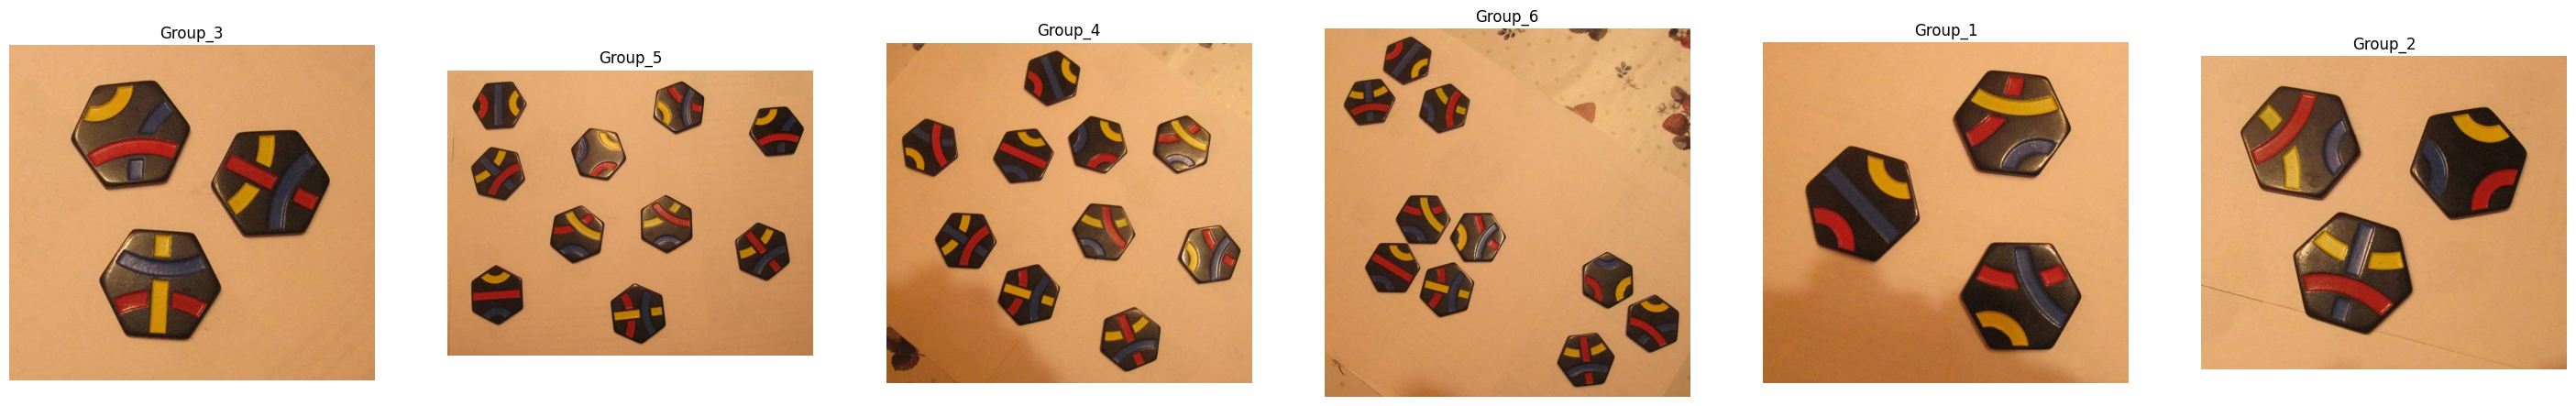

In [5]:
imshow('Group', images)

## `testbed and practice`

### Binarize

In [6]:
binarized = {}
thresh = {}
for key, img in images.items():
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    th, img_bin = cv2.threshold(img_gray, 128, 255, cv2.THRESH_OTSU)
    binarized[key] = img_bin
    thresh[key] = th

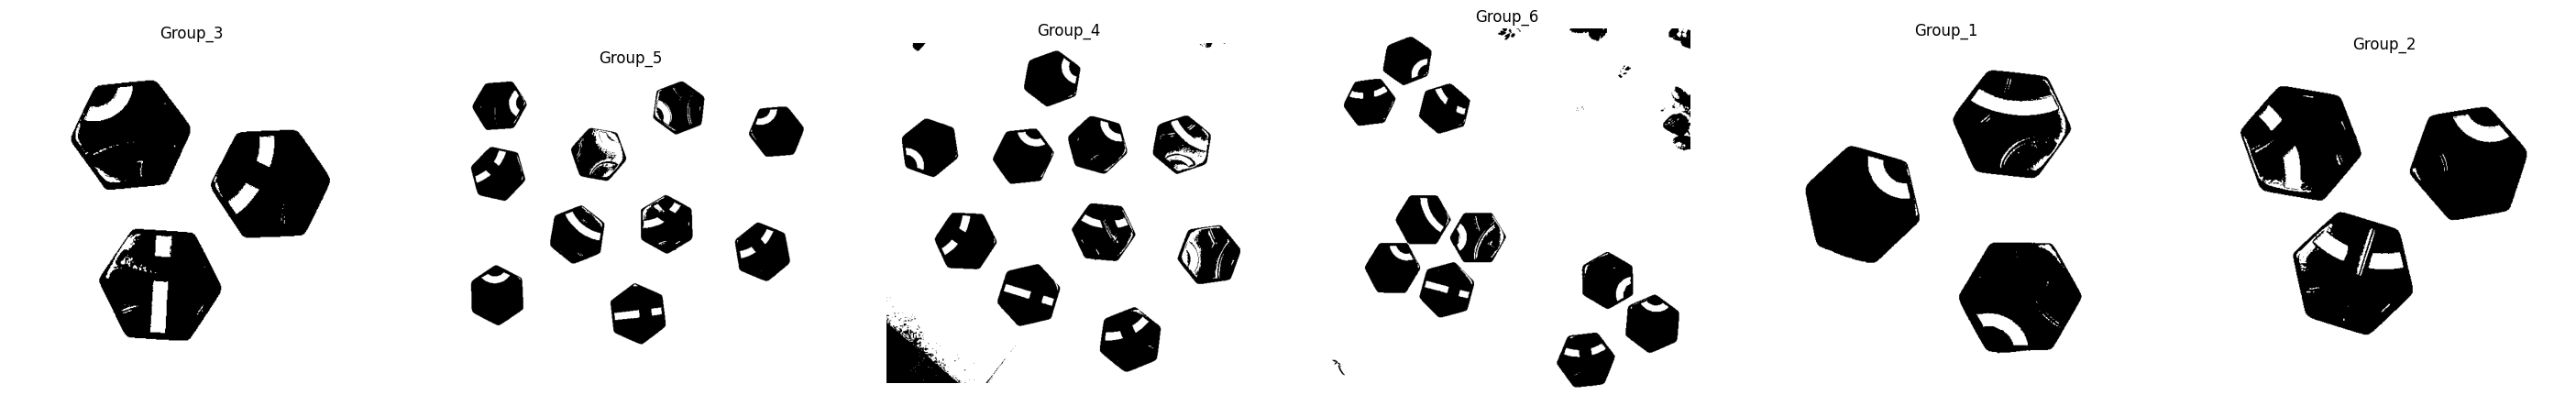

In [7]:
imshow('Group', binarized)

### Contours

In [8]:
def detect_shape(c):
    # Compute perimeter of contour and perform contour approximation
    shape = ""
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.04 * peri, True)

    if len(approx) == 6:
        shape = "hexagon"

    return shape

In [9]:
from collections import defaultdict
import numpy as np


tagged = {}
contoured = {}
for img in binarized.keys():
    contours, hierarchy = cv2.findContours(255-binarized[img], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    tagged[img] = cv2.cvtColor(binarized[img], cv2.COLOR_GRAY2RGB)
    
    # detect hexagons and collect areas
    hexagons = []
    areas = []
    for cnt in contours:
        shape = detect_shape(cnt)
        if shape != 'hexagon':
            continue

        hexagons.append(cnt)
        areas.append(cv2.contourArea(cnt))
        
        M = cv2.moments(cnt)
        cX = int((M["m10"] + 1e-3) / (M["m00"] + 1e-3))
        cY = int((M["m01"] + 1e-3) / (M["m00"] + 1e-3))
        
        cv2.putText(tagged[img], shape, (cX - 20, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
    
    contoured[img] = cv2.drawContours(tagged[img], hexagons, -1, (255, 0, 0), 10)

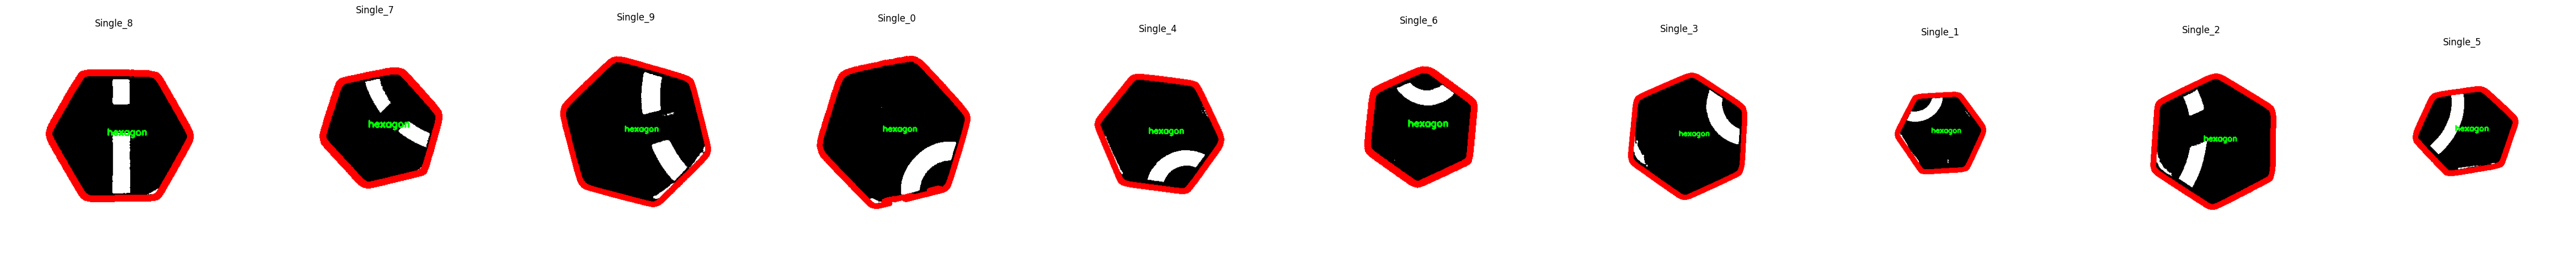

In [10]:
imshow('Single', contoured, figname='test')

### Extract Colors (archive)

In [88]:
yellow_range = ((18, 70, 0), (40, 170, 255))
red_range = ((0, 150, 20), (10, 255, 255))
blue_range = ((0,0,0), (255,80,255))

In [89]:
def colors(prefix, range, figname=None):
    keys = [key for key in images.keys() if key.startswith(prefix)]
    n = len(keys)
    _, ax = plt.subplots(2, n, figsize=(n*6, 12))
    for i, key in enumerate(keys):
        hsv = cv2.cvtColor(images[key], cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv, range[0], range[1])
        
        ax[0, i].imshow(images[key])
        ax[0, i].axis('off')
        ax[0, i].set_title(key)

        ax[1, i].imshow(mask)
        ax[1, i].axis('off')

    if figname is not None:
        plt.savefig(figname + '.svg')

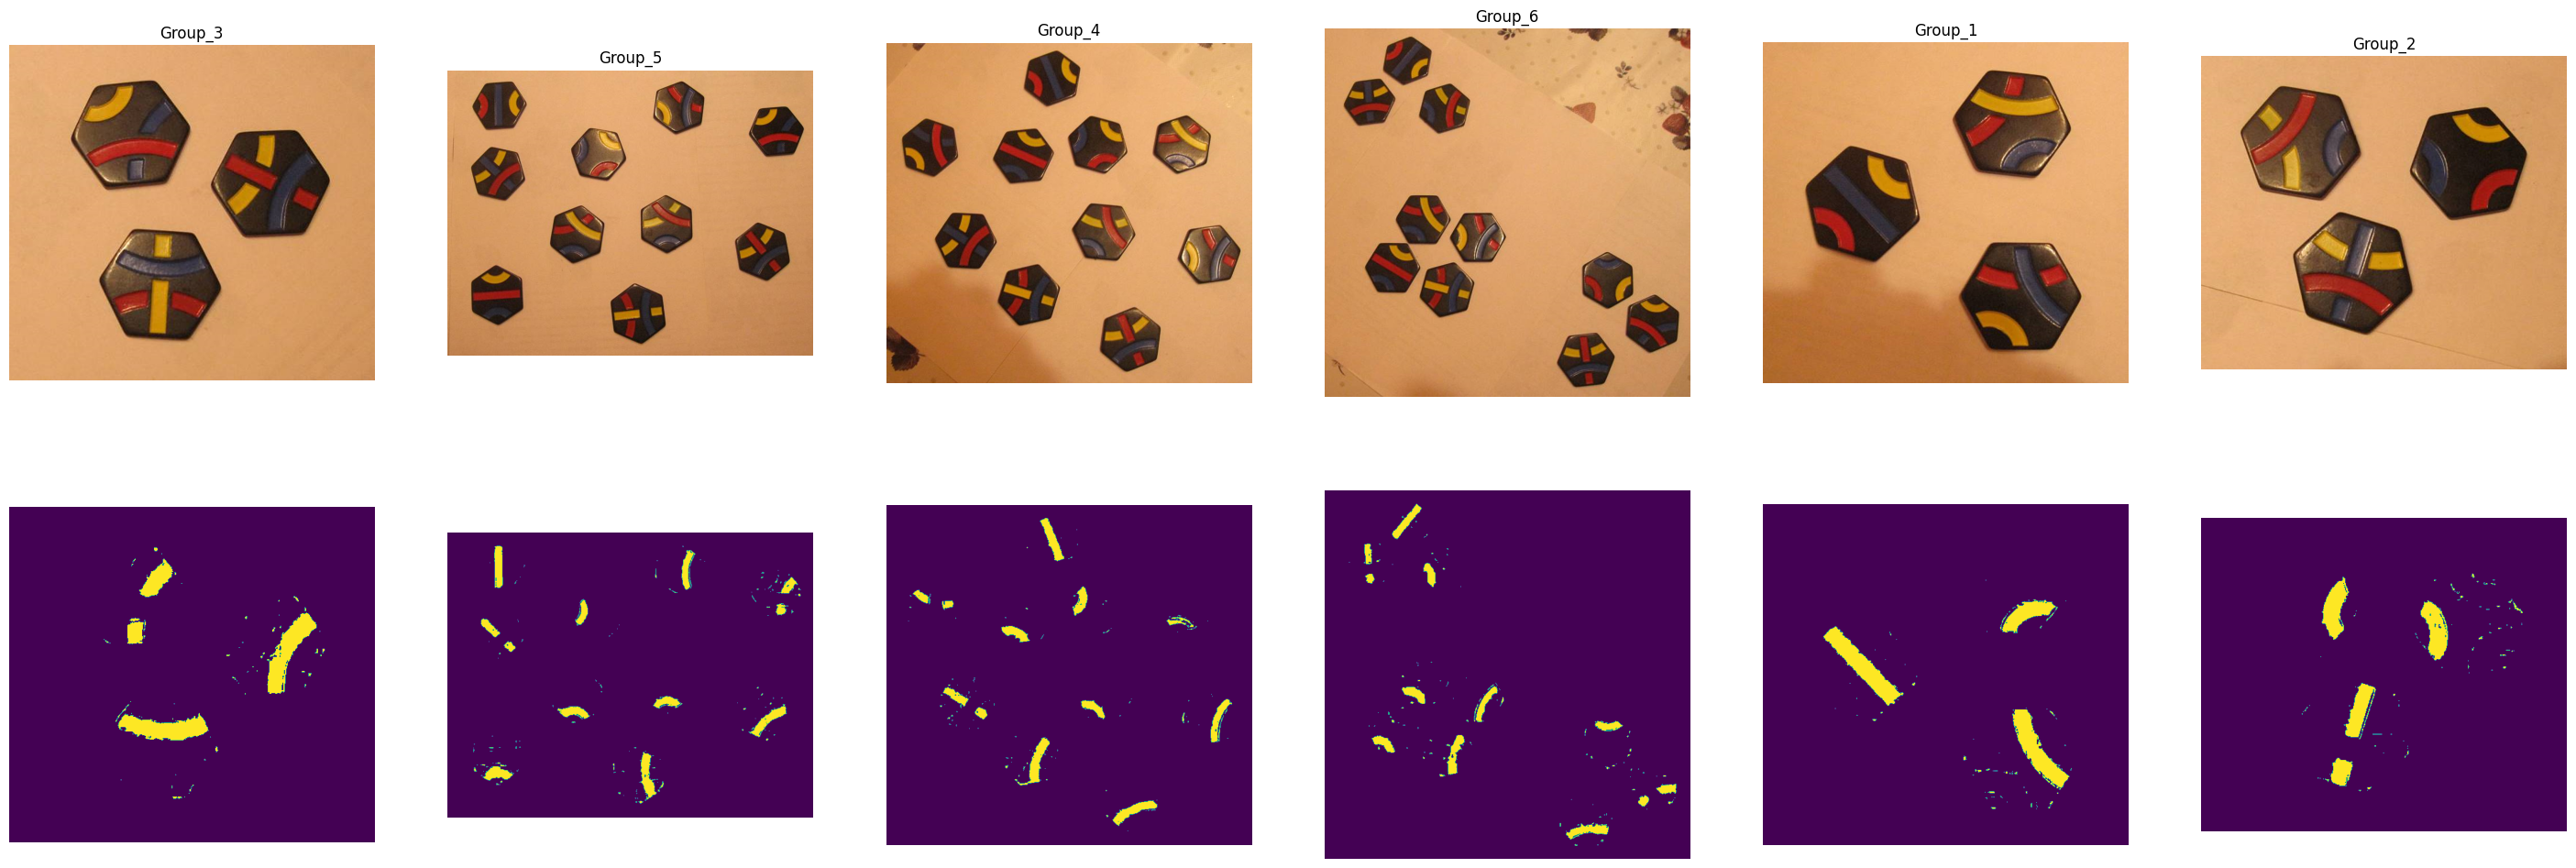

In [90]:
colors('Group', blue_range)

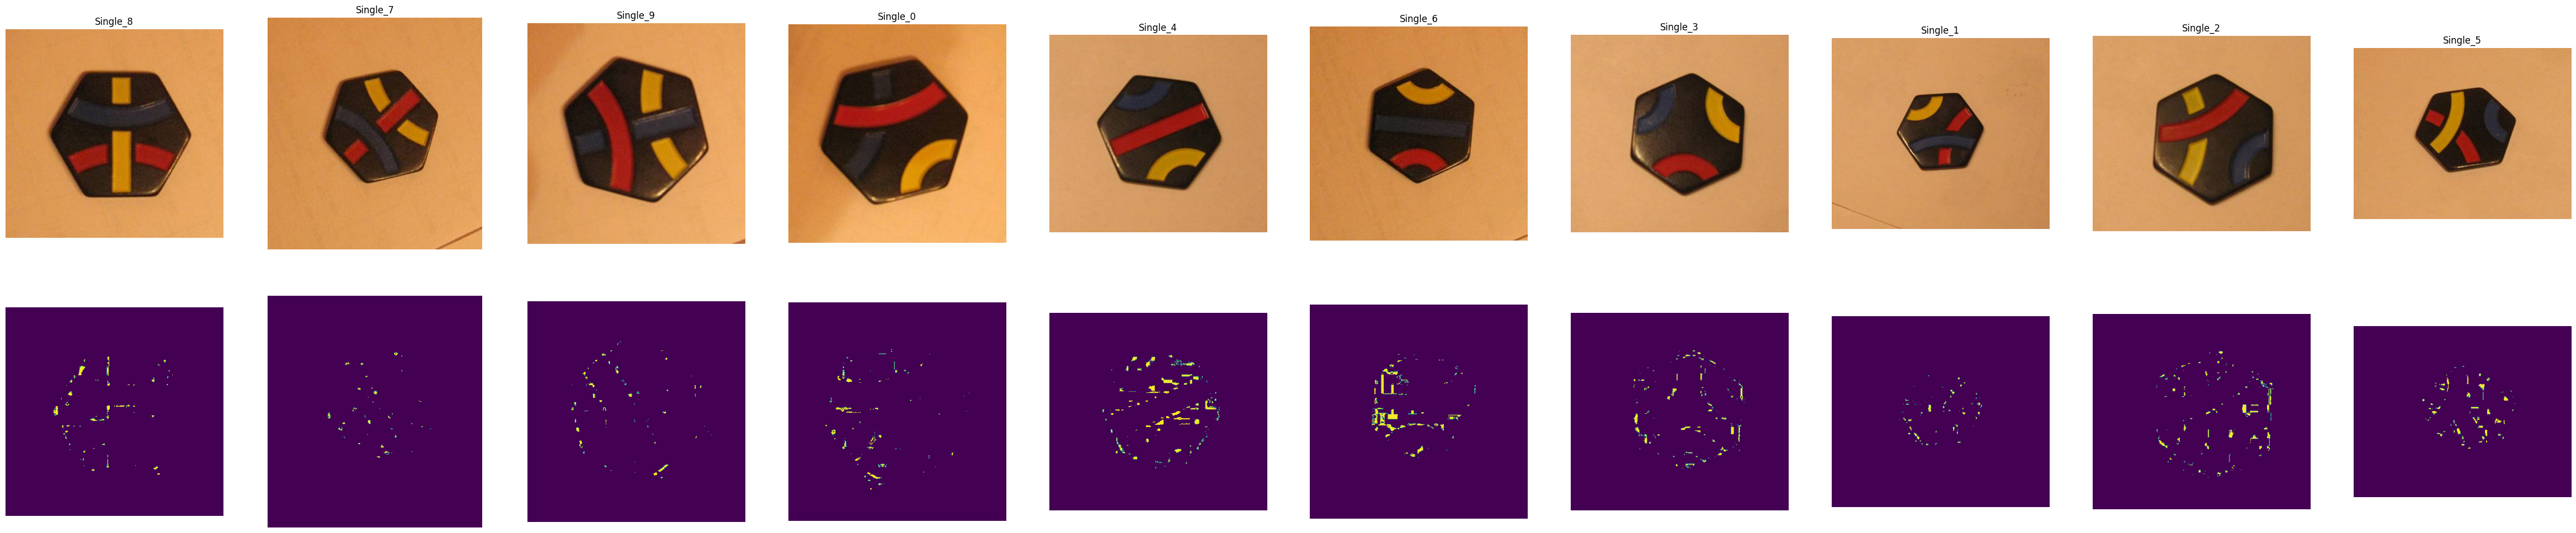

In [91]:
colors('Single', yellow_range, 'yellow')

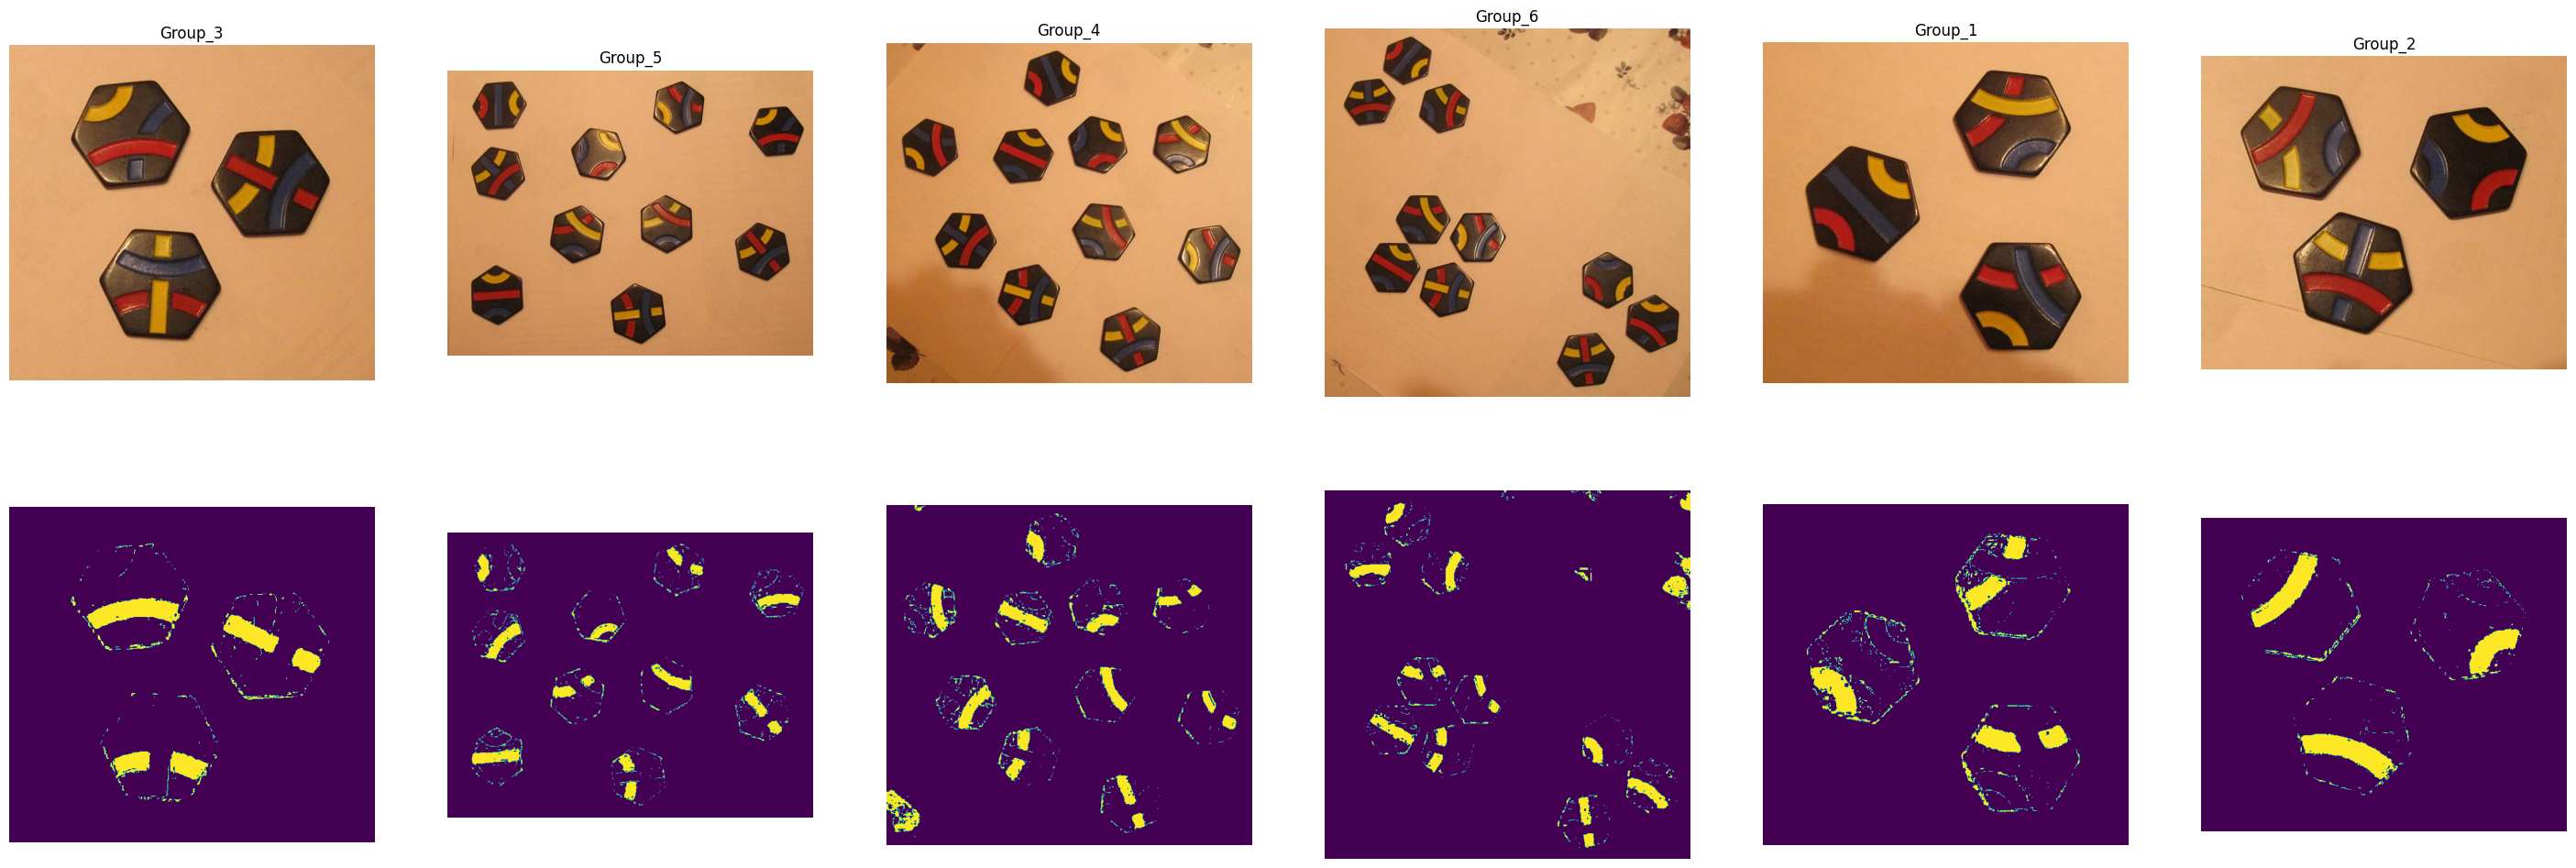

In [92]:
colors('Group', red_range, 'red')

### Find masks

In [11]:
tagged = {}
contoured = {}
hexagons = defaultdict(list)

for img in binarized.keys():
    contours, hierarchy = cv2.findContours(255-binarized[img], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    tagged[img] = cv2.cvtColor(binarized[img], cv2.COLOR_GRAY2RGB)
    
    areas = []
    for i, cnt in enumerate(contours):
        shape = detect_shape(cnt)
        if shape != 'hexagon':
            continue

        hexagons[img].append(cnt)
        
        M = cv2.moments(cnt)
        cX = int((M["m10"] + 1e-3) / (M["m00"] + 1e-3))
        cY = int((M["m01"] + 1e-3) / (M["m00"] + 1e-3))
        
        cv2.putText(tagged[img], shape, (cX - 20, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
    
    contoured[img] = cv2.drawContours(tagged[img], hexagons[img], -1, (255, 0, 0), 10)

filled = defaultdict(list)
for key in images.keys():
    for i, cnt in enumerate(hexagons[key]):
        shape = images[key].shape[0], images[key].shape[1]
        filled[key].append(cv2.drawContours(np.zeros(shape), hexagons[key], i, color=1, thickness=-1).astype(int))

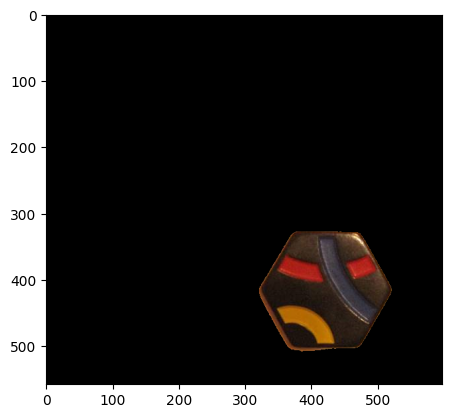

In [94]:
img = 'Group_1'
plt.imshow(filled[img][0][:,:,None] * images[img])

### Find masks + crop

In [40]:
hexagons = defaultdict(list)

for img in binarized.keys():
    contours, hierarchy = cv2.findContours(255-binarized[img], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for i, cnt in enumerate(contours):
        shape = detect_shape(cnt)
        if shape != 'hexagon':
            continue

        hexagons[img].append(cnt)

In [41]:
detected = defaultdict(list)
masks = defaultdict(list)
for key in images.keys():
    for i, cnt in enumerate(hexagons[key]):
        x, y, w, h = cv2.boundingRect(cnt)
        shape = images[key].shape[0], images[key].shape[1]  # because images has shape (H,W,C) but we need (H,W)
        mask = cv2.drawContours(np.zeros(shape), hexagons[key], i, color=1, thickness=-1).astype(int)
        cropped_mask = mask[y:y+h, x:x:w]
        masked = images[key] * mask[..., None]
        cropped = masked[y:y+h, x:x+w]
        resized = cv2.resize(cropped.astype(float), (16,16)).astype(int)
        detected[key].append(resized)
        masks[key].append((resized != 0).astype(float)[:,:,0])

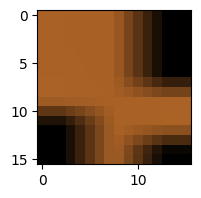

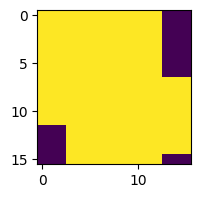

In [42]:
key = 'Group_4'
for img in detected[key][:1]:
    plt.figure(figsize=(2,2))
    plt.imshow(img)
    plt.show()
for img in masks[key][:1]:
    plt.figure(figsize=(2,2))
    plt.imshow(img)
    plt.show()

## Hexagon Extraction

In [98]:
import numpy as np
a = np.empty((3, 320, 240))
np.moveaxis(a, 0, -1).shape

(320, 240, 3)

In [99]:
def get_hexagons(dir_path='../images/', output_shape=(64,64)):
    """
    Returns:
    --------
    detected:
        detected[img_filename] = [hex1, hex2, ...]
        hex{i} is numpy array of shape (256,256,3), cropped and masked chip
    centers:
        centers[img_filename] = [c1, c2, ...]
        c{i} is tuple (x,y), center of hex{i}
    """
    # load images
    files = glob(dir_path + '*.bmp')
    images = {}
    for file in files:
        img = cv2.imread(file, cv2.IMREAD_COLOR)
        # images[name] is numpy array of shape (H,W,C)
        images[file[10:-4]] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # binarize with otsu method (because findContours needs binized image)
    binarized = {}
    thresh = {}
    for key, img in images.items():
        # to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # binarize
        th, img_bin = cv2.threshold(img_gray, 128, 255, cv2.THRESH_OTSU)
        
        binarized[key] = img_bin
        thresh[key] = th

    # find all hexagons on image
    hexagons = defaultdict(list)
    centers = defaultdict(list)
    for key in binarized.keys():
        # main procedure
        contours, _ = cv2.findContours(255-binarized[key], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            # compute perimeter of contour
            peri = cv2.arcLength(cnt, True)
            # perform contour approximation
            approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)

            # filter non hexagons
            if len(approx) != 6:
                continue
            
            # find center of hexagon
            M = cv2.moments(cnt)
            x = int((M["m10"] + 1e-3) / (M["m00"] + 1e-3))
            y = int((M["m01"] + 1e-3) / (M["m00"] + 1e-3))
            
            centers[key].append((x, y))
            hexagons[key].append(cnt)

    # mask, crop and resize each hexagon
    detected = defaultdict(list)
    for key in images.keys():
        for i, cnt in enumerate(hexagons[key]):
            # coords for cropping
            x, y, w, h = cv2.boundingRect(cnt)
            
            # mask of hexagon
            shape = images[key].shape[0], images[key].shape[1]  # because images has shape (H,W,C) but we need (H,W)
            mask_ = cv2.drawContours(zeros(shape), hexagons[key], i, color=1, thickness=-1).astype(int)
            
            # we need to broadcast `mask` manually
            mask = np.array([mask_, mask_, mask_])
            mask = np.moveaxis(mask, 0, -1)

            # remove everything except the hexagon
            masked = images[key] * mask
            
            # add white background
            masked[mask == 0] = 255

            # crop
            cropped = masked[y:y+h, x:x+w].astype(float)

            # resize
            resized = cv2.resize(cropped, output_shape).astype(int)

            detected[key].append(resized)
    
    return detected, centers

In [104]:
detected, centers = get_hexagons(output_shape=(32,32))

In [105]:
print(centers.keys())
print(detected.keys())

dict_keys(['Path_5', 'Single_8', 'Single_7', 'Single_9', 'Dozen_0', 'Path_6', 'Group_3', 'Single_0', 'Single_4', 'Single_6', 'Group_5', 'Group_4', 'Single_3', 'Group_6', 'Group_1', 'Single_1', 'Single_2', 'Path_9', 'Single_5', 'Group_2', 'Path_7'])
dict_keys(['Path_5', 'Single_8', 'Single_7', 'Single_9', 'Dozen_0', 'Path_6', 'Group_3', 'Single_0', 'Single_4', 'Single_6', 'Group_5', 'Group_4', 'Single_3', 'Group_6', 'Group_1', 'Single_1', 'Single_2', 'Path_9', 'Single_5', 'Group_2', 'Path_7'])


(196, 198)


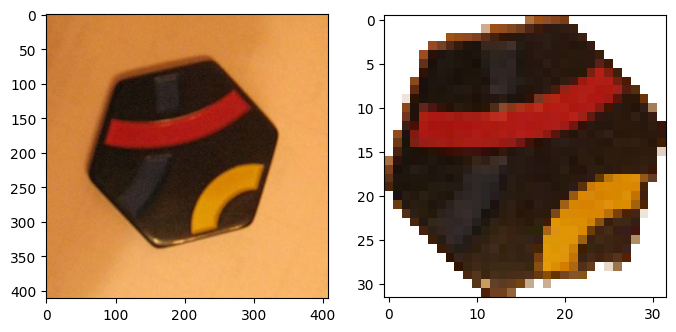

In [106]:
key = 'Single_0'
i = 0
print(centers[key][i])

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(images[key])
ax[1].imshow(detected[key][i])

In [107]:
for key in images.keys():
    for i, img in enumerate(detected[key]):
        img = img[:,:,::-1] # convert RGB to BGR
        cv2.imwrite(f'../detected/{key}-{i}.bmp', img)

## Shuffle Pixels

In [43]:
def shuffle_pixels(img, mask):
    pixels = []
    img = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if not mask[i, j]:
                continue
            pixels.append(img[i, j])
    np.random.shuffle(pixels)
    cnt = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if not mask[i,j]:
                continue
            img[i, j] = \
                  pixels[cnt]
            cnt += 1
    img[mask == 0] = 255
    return img

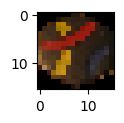

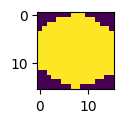

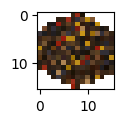

In [44]:
key = 'Single_2'
img = detected[key][0]
mask = masks[key][0]
shuffled = shuffle_pixels(img, mask)
for pic in [img, mask, shuffled]:
    plt.figure(figsize=(1,1))
    plt.imshow(pic)

In [47]:
for key in images.keys():
    for i, img in enumerate(detected[key]):
        img = img[:,:,::-1] # convert RGB to BGR
        cv2.imwrite(f'../shuffled/{key}-{i}.bmp', shuffle_pixels(img, masks[key][i]))